In [28]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
mnist = tf.keras.datasets.mnist

In [29]:
BATCH_SIZE = 32
BUFFER_SIZE = 10000

In [30]:
data_dir = "../data/mnist"
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

AttributeError: 'BatchDataset' object has no attribute '__iterator__'

#### Sanity Check

Letter: 2


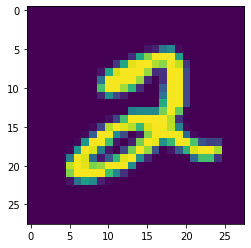

In [15]:
print("Letter: {}".format(y_train[5]))
plt.imshow(x_train[5])

In [19]:
READ_ATTN = True
WRITE_ATTN = True

In [20]:
A, B = 28, 28  # image width,height
img_size = B * A  # the canvas size
enc_size = 256  # number of hidden units / output size in LSTM
dec_size = 256
read_n = 5  # read glimpse grid width/height
write_n = 5  # write glimpse grid width/height
read_size = 2 * read_n * read_n if READ_ATTN else 2 * img_size
write_size = write_n * write_n if WRITE_ATTN else img_size
z_size = 10  # QSampler output size
T = 10  # MNIST generation sequence length
batch_size = 100  # training minibatch size
train_iters = 10000
learning_rate = 1e-3  # learning rate for optimizer
eps = 1e-8  # epsilon for numerical stability

In [24]:
read_size

50

In [1]:
#!/usr/bin/env python

""""
Simple implementation of http://arxiv.org/pdf/1502.04623v2.pdf in TensorFlow

Example Usage: 
	python draw.py --data_dir=/tmp/draw --read_attn=True --write_attn=True

Author: Eric Jang
"""

import tensorflow as tf
from tensorflow.examples.tutorials import mnist
import numpy as np
import os

tf.flags.DEFINE_string("data_dir", "", "")
tf.flags.DEFINE_boolean("read_attn", True, "enable attention for reader")
tf.flags.DEFINE_boolean("write_attn", True, "enable attention for writer")
FLAGS = tf.flags.FLAGS

## MODEL PARAMETERS ##

A, B = 28, 28  # image width,height
img_size = B * A  # the canvas size
enc_size = 256  # number of hidden units / output size in LSTM
dec_size = 256
read_n = 5  # read glimpse grid width/height
write_n = 5  # write glimpse grid width/height
read_size = 2 * read_n * read_n if FLAGS.read_attn else 2 * img_size
write_size = write_n * write_n if FLAGS.write_attn else img_size
z_size = 10  # QSampler output size
T = 10  # MNIST generation sequence length
batch_size = 100  # training minibatch size
train_iters = 10000
learning_rate = 1e-3  # learning rate for optimizer
eps = 1e-8  # epsilon for numerical stability

## BUILD MODEL ##

DO_SHARE = None  # workaround for variable_scope(reuse=True)

x = tf.placeholder(
    tf.float32, shape=(batch_size, img_size)
)  # input (batch_size * img_size)
e = tf.random_normal((batch_size, z_size), mean=0, stddev=1)  # Qsampler noise
lstm_enc = tf.contrib.rnn.LSTMCell(enc_size, state_is_tuple=True)  # encoder Op
lstm_dec = tf.contrib.rnn.LSTMCell(dec_size, state_is_tuple=True)  # decoder Op


def linear(x, output_dim):
    """
    affine transformation Wx+b
    assumes x.shape = (batch_size, num_features)
    """
    w = tf.get_variable("w", [x.get_shape()[1], output_dim])
    b = tf.get_variable("b", [output_dim], initializer=tf.constant_initializer(0.0))
    return tf.matmul(x, w) + b


def filterbank(gx, gy, sigma2, delta, N):
    grid_i = tf.reshape(tf.cast(tf.range(N), tf.float32), [1, -1])
    mu_x = gx + (grid_i - N / 2 - 0.5) * delta  # eq 19
    mu_y = gy + (grid_i - N / 2 - 0.5) * delta  # eq 20
    a = tf.reshape(tf.cast(tf.range(A), tf.float32), [1, 1, -1])
    b = tf.reshape(tf.cast(tf.range(B), tf.float32), [1, 1, -1])
    mu_x = tf.reshape(mu_x, [-1, N, 1])
    mu_y = tf.reshape(mu_y, [-1, N, 1])
    sigma2 = tf.reshape(sigma2, [-1, 1, 1])
    Fx = tf.exp(-tf.square(a - mu_x) / (2 * sigma2))
    Fy = tf.exp(-tf.square(b - mu_y) / (2 * sigma2))  # batch x N x B
    # normalize, sum over A and B dims
    Fx = Fx / tf.maximum(tf.reduce_sum(Fx, 2, keep_dims=True), eps)
    Fy = Fy / tf.maximum(tf.reduce_sum(Fy, 2, keep_dims=True), eps)
    return Fx, Fy


def attn_window(scope, h_dec, N):
    with tf.variable_scope(scope, reuse=DO_SHARE):
        params = linear(h_dec, 5)
    # gx_,gy_,log_sigma2,log_delta,log_gamma=tf.split(1,5,params)
    gx_, gy_, log_sigma2, log_delta, log_gamma = tf.split(params, 5, 1)
    gx = (A + 1) / 2 * (gx_ + 1)
    gy = (B + 1) / 2 * (gy_ + 1)
    sigma2 = tf.exp(log_sigma2)
    delta = (max(A, B) - 1) / (N - 1) * tf.exp(log_delta)  # batch x N
    return filterbank(gx, gy, sigma2, delta, N) + (tf.exp(log_gamma),)


## READ ##
def read_no_attn(x, x_hat, h_dec_prev):
    return tf.concat([x, x_hat], 1)


def read_attn(x, x_hat, h_dec_prev):
    Fx, Fy, gamma = attn_window("read", h_dec_prev, read_n)

    def filter_img(img, Fx, Fy, gamma, N):
        Fxt = tf.transpose(Fx, perm=[0, 2, 1])
        img = tf.reshape(img, [-1, B, A])
        glimpse = tf.matmul(Fy, tf.matmul(img, Fxt))
        glimpse = tf.reshape(glimpse, [-1, N * N])
        return glimpse * tf.reshape(gamma, [-1, 1])

    x = filter_img(x, Fx, Fy, gamma, read_n)  # batch x (read_n*read_n)
    x_hat = filter_img(x_hat, Fx, Fy, gamma, read_n)
    return tf.concat([x, x_hat], 1)  # concat along feature axis


read = read_attn if FLAGS.read_attn else read_no_attn

## ENCODE ##
def encode(state, input):
    """
    run LSTM
    state = previous encoder state
    input = cat(read,h_dec_prev)
    returns: (output, new_state)
    """
    with tf.variable_scope("encoder", reuse=DO_SHARE):
        return lstm_enc(input, state)


## Q-SAMPLER (VARIATIONAL AUTOENCODER) ##


def sampleQ(h_enc):
    """
    Samples Zt ~ normrnd(mu,sigma) via reparameterization trick for normal dist
    mu is (batch,z_size)
    """
    with tf.variable_scope("mu", reuse=DO_SHARE):
        mu = linear(h_enc, z_size)
    with tf.variable_scope("sigma", reuse=DO_SHARE):
        logsigma = linear(h_enc, z_size)
        sigma = tf.exp(logsigma)
    return (mu + sigma * e, mu, logsigma, sigma)


## DECODER ##
def decode(state, input):
    with tf.variable_scope("decoder", reuse=DO_SHARE):
        return lstm_dec(input, state)


## WRITER ##
def write_no_attn(h_dec):
    with tf.variable_scope("write", reuse=DO_SHARE):
        return linear(h_dec, img_size)


def write_attn(h_dec):
    with tf.variable_scope("writeW", reuse=DO_SHARE):
        w = linear(h_dec, write_size)  # batch x (write_n*write_n)
    N = write_n
    w = tf.reshape(w, [batch_size, N, N])
    Fx, Fy, gamma = attn_window("write", h_dec, write_n)
    Fyt = tf.transpose(Fy, perm=[0, 2, 1])
    wr = tf.matmul(Fyt, tf.matmul(w, Fx))
    wr = tf.reshape(wr, [batch_size, B * A])
    # gamma=tf.tile(gamma,[1,B*A])
    return wr * tf.reshape(1.0 / gamma, [-1, 1])


write = write_attn if FLAGS.write_attn else write_no_attn

## STATE VARIABLES ##

cs = [0] * T  # sequence of canvases
mus, logsigmas, sigmas = (
    [0] * T,
    [0] * T,
    [0] * T,
)  # gaussian params generated by SampleQ. We will need these for computing loss.
# initial states
h_dec_prev = tf.zeros((batch_size, dec_size))
enc_state = lstm_enc.zero_state(batch_size, tf.float32)
dec_state = lstm_dec.zero_state(batch_size, tf.float32)

## DRAW MODEL ##

# construct the unrolled computational graph
for t in range(T):
    c_prev = tf.zeros((batch_size, img_size)) if t == 0 else cs[t - 1]
    x_hat = x - tf.sigmoid(c_prev)  # error image
    r = read(x, x_hat, h_dec_prev)
    h_enc, enc_state = encode(enc_state, tf.concat([r, h_dec_prev], 1))
    z, mus[t], logsigmas[t], sigmas[t] = sampleQ(h_enc)
    h_dec, dec_state = decode(dec_state, z)
    cs[t] = c_prev + write(h_dec)  # store results
    h_dec_prev = h_dec
    DO_SHARE = True  # from now on, share variables

## LOSS FUNCTION ##


def binary_crossentropy(t, o):
    return -(t * tf.log(o + eps) + (1.0 - t) * tf.log(1.0 - o + eps))


# reconstruction term appears to have been collapsed down to a single scalar value (rather than one per item in minibatch)
x_recons = tf.nn.sigmoid(cs[-1])

# after computing binary cross entropy, sum across features then take the mean of those sums across minibatches
Lx = tf.reduce_sum(binary_crossentropy(x, x_recons), 1)  # reconstruction term
Lx = tf.reduce_mean(Lx)

kl_terms = [0] * T
for t in range(T):
    mu2 = tf.square(mus[t])
    sigma2 = tf.square(sigmas[t])
    logsigma = logsigmas[t]
    kl_terms[t] = (
        0.5 * tf.reduce_sum(mu2 + sigma2 - 2 * logsigma, 1) - 0.5
    )  # each kl term is (1xminibatch)
KL = tf.add_n(
    kl_terms
)  # this is 1xminibatch, corresponding to summing kl_terms from 1:T
Lz = tf.reduce_mean(KL)  # average over minibatches

cost = Lx + Lz

## OPTIMIZER ##

optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.5)
grads = optimizer.compute_gradients(cost)
for i, (g, v) in enumerate(grads):
    if g is not None:
        grads[i] = (tf.clip_by_norm(g, 5), v)  # clip gradients
train_op = optimizer.apply_gradients(grads)

## RUN TRAINING ##

data_directory = os.path.join(FLAGS.data_dir, "mnist")
if not os.path.exists(data_directory):
    os.makedirs(data_directory)
train_data = mnist.input_data.read_data_sets(
    data_directory, one_hot=True
).train  # binarized (0-1) mnist data

fetches = []
fetches.extend([Lx, Lz, train_op])
Lxs = [0] * train_iters
Lzs = [0] * train_iters

sess = tf.InteractiveSession()

saver = tf.train.Saver()  # saves variables learned during training
tf.global_variables_initializer().run()
saver.restore(
    sess, "/tmp/draw/drawmodel_noattn.ckpt"
)  # to restore from model, uncomment this line

for i in range(train_iters):
    xtrain, _ = train_data.next_batch(batch_size)  # xtrain is (batch_size x img_size)
    feed_dict = {x: xtrain}
    results = sess.run(fetches, feed_dict)
    Lxs[i], Lzs[i], _ = results
    if i % 100 == 0:
        print("iter=%d : Lx: %f Lz: %f" % (i, Lxs[i], Lzs[i]))

## TRAINING FINISHED ##

canvases = sess.run(cs, feed_dict)  # generate some examples
canvases = np.array(canvases)  # T x batch x img_size

out_file = os.path.join(FLAGS.data_dir, "draw_data.npy")
np.save(out_file, [canvases, Lxs, Lzs])
print("Outputs saved in file: %s" % out_file)

ckpt_file = os.path.join(FLAGS.data_dir, "drawmodel.ckpt")
print("Model saved in file: %s" % saver.save(sess, ckpt_file))

sess.close()


ModuleNotFoundError: No module named 'tensorflow.examples.tutorials'